# Introduction to **A**uto**R**egressive **I**ntegrated **M**oving **A**verage (ARIMA) Modelling

**In this practical you will learn:**

* How to automatically select ARIMA model parameters by minimising AIC
* How to fit an ARIMA model to a time series
* How to obtain a point forecast and prediction intervals using ARIMA
* How to use `pmdarima`'s built in cross validation tools

# Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA specific imports

There are two main libraries for ARIMA modelling in Python: `statsmodels` and `pmdarima`.  The latter builds a powerful package of tools on top of `statsmodels` to support ARIMA modelling.  We are going to primarily work with `pmdarima`

In [2]:
from pmdarima import auto_arima, ARIMA

# Notebook helper functions

In [19]:
def arima_preds_to_dataframe(y_train, preds, intervals):
    '''
    pdmarima.ARIMA models return point forecasts and prediction intervals
    as numpy arrays.  This function converts them into data frames with a
    DateTimeIndex.
    
    Parameters:
    ---------
    y_train: pd.DataFrame or pd.Series
        Training data
        
    preds: np.array
        point forecasts
        
    intervals: np.array
        matrix - prediction intervals
        
    Returns:
    -------
        pd.DataFrame['mean'], pd.DataFrame['lower'. 'upper']
        
    '''
    pred_idx = pd.date_range(start=y_train.index[-1], periods=len(preds)+1, 
                             freq=y_train.index.freq)[1:]
    
    preds = pd.DataFrame(preds, index=pred_idx)
    preds.columns = ['mean']
    intervals = pd.DataFrame(intervals, index=pred_idx)
    intervals.columns = ['lower', 'upper']
    
    return preds, intervals

# Data

We will use an time series of patients that reattend an ED within 7 days.  The data are held at the monthly level.

The data is held in the file `ed_reattends_mth.csv`

# Exercise 1: Read in and adjust

**Task:**

* Load `ed_reattends_mth.csv`
* Perform a calender adjustment of the data
* Plot the data
* Name the `pd.DataFrame` you create `y_train`

**Hints**

* The data is stored in UK day first format.
* Remember to set the freq of the DataTimeIndex


**Questions**:
* How would you describe the time series?


In [3]:
# your code here ...

Before we use ARIMA it is necessary to understand the a two concepts: **autocorrelation** and **stationarity**

# Autocorrelation 

Autocorrelation (sometimes called serial correlation) describes the correlation of air passengers at time $t$ with air passengers at $t-1, t-2, ... , t-n$. In other words autocorrelation is the correlation of an observation with itself at previous time periods.  Like correlation autocorrelation takes a value between -1.0 ans 1.0

Let's have a look at the autocorrelation in the training data.

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

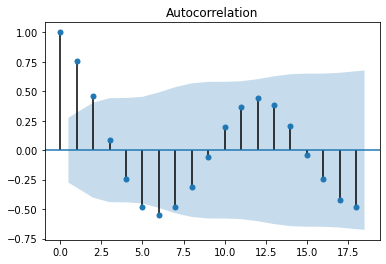

In [6]:
plot_acf(y_train);

Autocorrelation is a problem for traditional Ordinary Least Squares (OLS) regression because OLS assumes that the error process is normal i.i.d (independent and identitically distributed = there is no pattern).  In the ED 7-day Reattendance dataset this clearly isn't the case: there is significant autocorrelation up to lag 3 and possibly up to lag 6.

In the presence of autocorrelation, the standard errors of the coefficients from an OLS regression are too small and cannot be trusted. This is a substative problem for *inference* (i.e drawing the wrong conclusion, but and it is also a significant disadvantage for forecasting as we are ignoring information that could improve point predictions and prediction intervals.  

ARIMA models aim to describe the autocorrelations in the data. 

**AR** - Stands for Autoregressive. An AR(1) model is a regression model that includes a proportion of lag 1 Y value.  An AR(2) model includes a proportion of lag 1 and lag 2.  An AR(p) model includes a proportion of lags 1 to $p$.  An AR model of order p can be written as:

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} ⋯ \phi_p y_{t-p} + \epsilon_t$
* where $\epsilon_t$ is white noise (random error)
* The equation above looks like a regression with lagged variables of y


**MA** - Stands for Moving Average. An MA(1) model is a regression model that includes a proportion of the lag 1 forecast error value.  An MA(q) model includes a proportion of the errors from lag 1 to q.  An MA model of order q can be written as:

$y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} ⋯ \theta_q \epsilon_{t-q}$


ARIMA models can include a both AR and MA terms at the same time.

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} ⋯ \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} ⋯ \theta_q \epsilon_{t-q}$

#### Seasonal lags
ARIMA models can also include seasonal AR and MA terms (along with a seasonal period e.g 12 for monthly data). For example, an AR(P) model where P = 1 would include lag 12.  If P = 2 then it would include lag 12 and lag 24.

# Automatic selection of the 'best' ARIMA model.

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over and above the options available in core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember that the models we are working with are very flexible. This means that we can easily create complex models that overfit.  Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formaula for automatically selecting a good ARIMA forecasting model.

There's a large amount of theory about how to build an ARIMA model.  But modern applications tend to opt for the auto approach.

# Exercise 2: Using `auto_arima`

Let's use `auto_arima` keeping most parameters as their defaults initially.

**Task**: 

* Use `auto_arima` to find a model.  
* One a model is returned (it will take a few seconds) call `model.summary()` this will print out the models parameters.

**Hints**:
* This is monthly data.  We will need to set the parameter `m=12` so that the function knows the seasonal period.
* Not all models that the function attempts to fit will converge.  In these instances `statsmodels` will raise *warnings*.  To suppress these set `suppress_warnings=True`


In [7]:
# your code here ...

# Exercise 3: Forcing a first difference

The previous auto fitting returned a ARIMA(1, 0, 0)x(1, 0, 0, 12) model.  In this model `d=0` which means that the first stage of the auto fitting chose not to take a first difference.  Let's force `auto_arima` to fit models using a first difference of the data.

**Task:**
* rerun `auto_fit`, but set `d=1`


**Questions**
* Did the function return a different model?

In [9]:
# your code here ...

# Exercise 4: Manually creating a `ARIMA` model

In `pmdarima` you create an `ARIMA` object by passing in the (p, d, q) order and the (P, D, Q, m) seasonal order.
    
```python

#create an ARIMA object (suppress_warnings is optional)
model = ARIMA(order=(1, 0, 0), seasonal_order=(1, 0, 0, 12), 
              suppress_warnings=True)

#fit the model to the training data.
model.fit(y_train)

```

**Task:**

* Manually create and fit ARIMA model with `order=(3, 1, 0)` and `seasonal_order=(1, 0, 0, 12)`


In [12]:
# your code here ...

# Exercise 5: Making a prediction

To make a prediction with a `pmdarima.ARIMA` model use the `model.predict()` method.  This takes the parameters `n_periods` which is the forecast horizon.

```python
#return a numpy.array of predictions
preds = model.predict(n_periods=12)
```

You can (and should) also return a prediction interval with the point forecast. E.g. for a 95\% PI:

```python
#returns a tuple of (predictions, prediction_intervals)
preds, intervals = model.predict(n_periods=12, alpha=0.05, 
                                 return_conf_int=True)
```

 >Note: Both `pmdarima` and `statsmodels` call prediction intervals a confidence interval.  But that's technically incorrect!
 
**Task:**
* For each of the three models you have fitted make a 24 month forecast
* Return the point forecast and a 95% prediction interval.
* Plot each models forecast.

**Hints**:
* The `predict()` method returns a `numpy.ndarray`.  To help with plotting the forecast along with the training data it is useful to convert these into a `pandas.DataFrame` with a `DateTimeIndex`.  To do that, you can use the helper function `arima_preds_to_dataframe()`.

In [14]:
#your code here ...

## Exercise 6: Rolling Forecast Origin - Cross Validation

The module `pmdarima.model_selection` includes some built in cross validation tools for the ARIMA models.  Let's use these to compare the three models you have created over a 6 month horizon.

To import a rolling forecast origin functionality run the following code:

In [28]:
from pmdarima.model_selection import RollingForecastCV, cross_val_score

We will score forecast error using the mean absolute error metric.  

A template for cross validation is as follows:

```python
#6 month horizon that rolls the origin by 1 month at a time.
#by default it uses 1/3 of the data for initial training.
cv = RollingForecastCV(h=6, step=1)

#perform cv. (verbose controls the output to screen).
scores = cross_val_score(model_1, y_train, cv=cv, verbose=2, 
                              scoring='mean_absolute_error')

```

**Task:**
* Using 6 month horizon calculate the mean cross validation score for each model.

**Questions:**
* Which model do you prefer for point forecasts and why?  Was it a difficult decision?

In [ ]:
#your code here ...

# Exercise 7: Is the ARIMA model better than a Naive Forecast?

Let's calculate a cross validation score for the seasonal naive model and compare it to your chosen ARIMA model.  

**Task**:

* Using code provided below evaluate if your chosen ARIMA model relative to a Seaonal Naive forecast.

**Questions**:
* Are you happy with your chosen ARIMA model? Would select it over a seasonal naive model?

In [37]:
from forecast_tools.baseline import SNaive
from forecast_tools.metrics import mean_absolute_error

In [75]:
def rolling_forecast_origin(train, min_train_size, horizon):
    '''
    Rolling forecast origin generator.
    '''
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val

In [78]:
#loop through the generator and get MAE

h=6
min_train_size = len(y_train) // 3
snf = SNaive(period=12)

cv = rolling_forecast_origin(y_train, min_train_size=min_train_size, horizon=6)

scores_snf = []
for cv_train, cv_test in cv:
    snf.fit(cv_train)
    preds = snf.predict(h)
    score = mean_absolute_error(cv_test, preds)
    scores_snf.append(score)
    
scores_snf = np.array(scores_snf)

In [79]:
scores_snf.mean()

11.783881028790125